In [2]:
from importlib import reload
import parsing
import models
import model_interface
import visualization
reload(parsing)
reload(models)
reload(model_interface)
reload(visualization)

<module 'visualization' from '/home/deus/Documents/trajectory-prediction/visualization.py'>

In [3]:
# file_path = "data/small.csv"
file_path = "data/medium_aa.csv"
# file_path = "data/atc-20121114.csv"

train_data, eval_data, test_data = parsing.parse_atc_day(file_path, train_ratio=0.9, eval_ratio=0.1)
eval_data_x, eval_data_goals, eval_data_y = eval_data

  1%|          | 7/1224 [00:00<00:17, 69.46it/s]

           time       id      x      y         z  velocity  motion_angle  \
0  1.352853e+09  9315400  39830 -22779  1704.245   823.082        -0.499   
1  1.352853e+09  9330400  34873 -17618  1467.723  1280.126         2.821   
2  1.352853e+09  9330600  -9670   7396  1230.397  1095.896         2.322   
3  1.352853e+09  9315400  39848 -22802  1704.947   903.930        -0.648   
4  1.352853e+09  9330400  34830 -17590  1466.868  1302.011         2.751   

   facing_angle  
0        -0.708  
1         2.799  
2         2.357  
3        -0.732  
4         2.748  
time    float64
id        int64
x         int64
y         int64
dtype: object
           time       id      x      y
0  1.352853e+09  9315400  39830 -22779
1  1.352853e+09  9330400  34873 -17618
2  1.352853e+09  9330600  -9670   7396
3  1.352853e+09  9315400  39848 -22802
4  1.352853e+09  9330400  34830 -17590
0   2012-11-14 00:33:08.708000000
1   2012-11-14 00:33:08.708000000
2   2012-11-14 00:33:08.708000000
3   2012-11-14 00:33:

100%|██████████| 1224/1224 [00:16<00:00, 72.83it/s]


Dividing 697 human trajectories: 627 training, 70 eval, 0 test
train (226805, 40, 2) float64 (226805, 25) float32 (226805, 40, 2) float64
eval (22415, 40, 2) float64 (22415, 25) float32 (22415, 40, 2) float64


In [6]:
model = None
model, _ = models.simple_lstm(train_data, eval_data)
# model, _ = models.simple_lstm_goal(train_data, eval_data)

# model_no_goal, _ = models.simple_lstm(train_data, eval_data)
# model_goal, _ = models.simple_lstm_goal(train_data, eval_data)

Epoch 1/20
7088/7088 [==============================] - 21s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0355 - val_loss: 0.0027 - val_mean_absolute_error: 0.0336
Epoch 2/20
7088/7088 [==============================] - 20s 3ms/step - loss: 0.0027 - mean_absolute_error: 0.0326 - val_loss: 0.0025 - val_mean_absolute_error: 0.0316
Epoch 3/20
7088/7088 [==============================] - 20s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0320 - val_loss: 0.0026 - val_mean_absolute_error: 0.0322
Epoch 4/20
7088/7088 [==============================] - 21s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0316 - val_loss: 0.0025 - val_mean_absolute_error: 0.0311
Epoch 5/20
7088/7088 [==============================] - 21s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0315 - val_loss: 0.0025 - val_mean_absolute_error: 0.0314
Epoch 6/20
7088/7088 [==============================] - 21s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0313 - val_loss: 0.0025 - val_mean_absolute_error: 0.031

In [7]:
# eval_data_goal_x = model_interface.concatenate_x_goal(eval_data_x, eval_data_goals)
model_interface.calculate_final_metrics(model, eval_x=eval_data_x, eval_y=eval_data_y, filepath='no_goal_model_errors')
# model_interface.calculate_final_metrics(model, eval_x=eval_data_goal_x, eval_y=eval_data_y, filepath='goal_model_errors')

MED: 0.04988967905875525
FDE: 0.09320758756838872


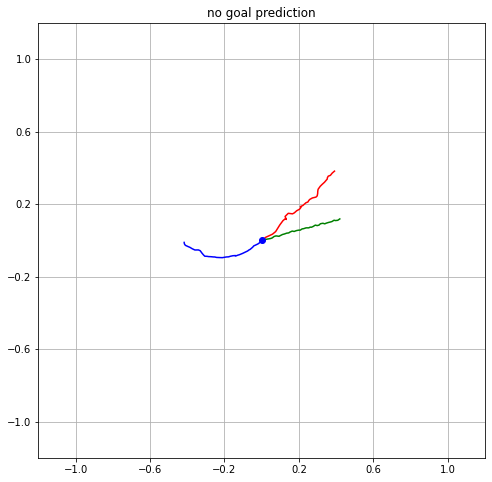

9 4 1


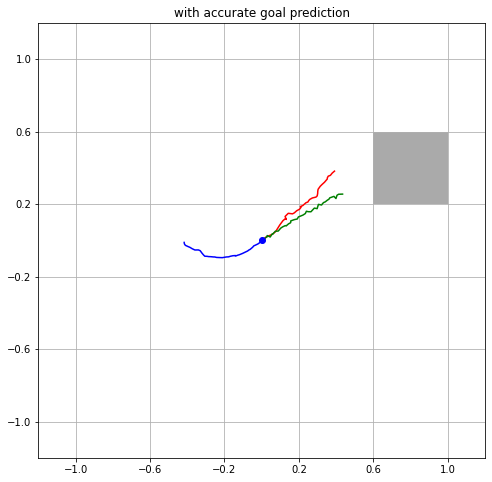

In [14]:

N = 0
visualization.draw_path(eval_data_x[N], eval_data_y[N], prediction_model=model_no_goal, name="no goal prediction")
visualization.draw_path(eval_data_x[N], eval_data_y[N], eval_data_goals[N], prediction_model=model_goal, name="with accurate goal prediction")